In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

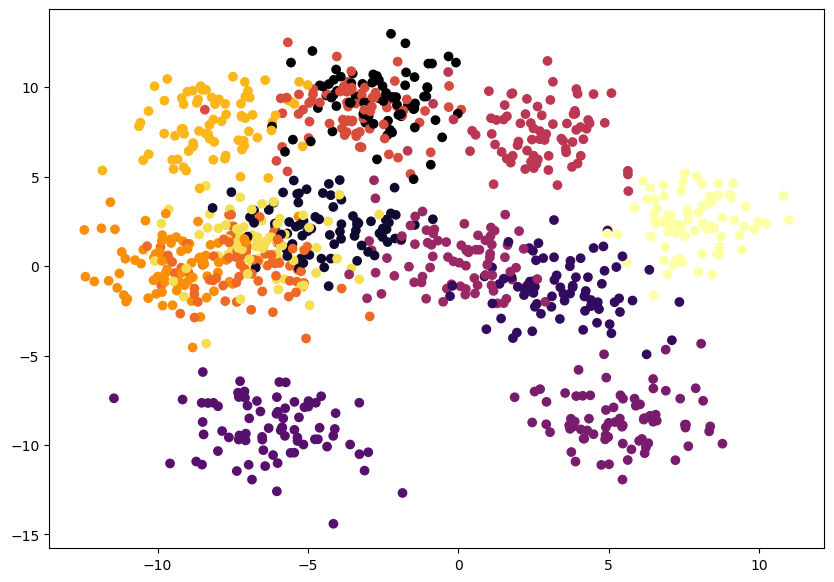

In [2]:



NUM_CLASSES = 13
NUM_FEATURES = 19
RANDOM_SEED = 42

x_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

x_blob = torch.from_numpy(x_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

x_blob_train, x_blob_test, y_blob_train, y_blob_test = train_test_split(x_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

plt.figure(figsize=(10, 7))
plt.scatter(x_blob[:,0], x_blob[:,1], c=y_blob, cmap=plt.cm.inferno
            )

In [3]:

device  = "cuda" if torch.cuda.is_available() else "cpu"


class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hiden_units = 32, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hiden_units),
            nn.ReLU(),
            nn.Linear(in_features=hiden_units, out_features=hiden_units),
            nn.ReLU(),
            nn.Linear(in_features=hiden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)
    
model_4 = BlobModel(input_features=19, output_features=13).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=19, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=13, bias=True)
  )
)

In [4]:
loss_fn = nn.CrossEntropyLoss()
optimezer = torch.optim.SGD(params=model_4.parameters(), lr=0.1)
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [5]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(x_blob_test.to(device))

y_preds_probs = torch.softmax(y_logits, dim=1)

y_preds = torch.argmax(y_preds_probs, dim=1)
y_preds

tensor([ 8,  6,  5,  9,  7,  9,  9,  8,  3,  7,  9, 10,  8,  1,  4,  9,  9,  1,
        10,  7,  7, 12, 10, 10,  8,  3, 10,  6,  7,  9,  6, 12,  4, 10,  4, 12,
        10,  9, 12,  3,  3,  1,  4,  9,  9, 10,  6,  9,  4, 12,  7, 10,  7, 12,
         9, 10,  7,  8,  7,  7,  5,  8,  4,  9,  5, 10,  7, 12, 12, 12,  9,  4,
         7,  5,  7, 12, 10,  7, 12, 10, 10,  4, 10, 12,  9,  1,  9,  7,  3,  9,
         7,  3,  5,  3,  7,  9, 12,  7,  1, 10, 10,  9,  4,  3, 10,  9,  7, 12,
         9,  9,  9, 12, 10,  7,  4,  1, 12, 12,  3,  7,  7,  7,  6,  7,  7,  7,
         7, 10,  7,  7,  7,  7,  1,  7,  7,  8, 12,  9,  9, 12, 12,  9, 10,  7,
         4,  7,  9,  7,  7,  1,  9, 10,  4,  1,  4,  4,  1, 10,  4,  6,  5,  1,
        12, 10,  5,  8,  8,  7,  9,  7, 10,  9,  9, 10,  1,  7,  4,  9, 12, 12,
         9,  4,  7,  7,  8,  9, 12, 12, 10, 12, 12,  3,  2, 12, 12,  4,  8,  7,
         7, 10])

In [6]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

x_blob_train, y_blob_train = x_blob_train.to(device), y_blob_train.to(device)
x_blob_test, y_blob_test = x_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    model_4.train()
    y_logits = model_4(x_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train, y_pred = y_pred)
    optimezer.zero_grad()
    loss.backward()
    optimezer.step()

    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(x_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_preds)


    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:4f}, acc: {acc:.2f}| Test Loss: {test_loss} Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 2.706295, acc: 4.25| Test Loss: 2.474975347518921 Test Acc: 15.00%
Epoch: 10 | Loss: 0.687566, acc: 99.50| Test Loss: 0.5911141037940979 Test Acc: 100.00%
Epoch: 20 | Loss: 0.107719, acc: 100.00| Test Loss: 0.09610787034034729 Test Acc: 100.00%
Epoch: 30 | Loss: 0.043703, acc: 100.00| Test Loss: 0.04056303948163986 Test Acc: 100.00%
Epoch: 40 | Loss: 0.025803, acc: 100.00| Test Loss: 0.024291981011629105 Test Acc: 100.00%
Epoch: 50 | Loss: 0.017828, acc: 100.00| Test Loss: 0.01689906045794487 Test Acc: 100.00%
Epoch: 60 | Loss: 0.013420, acc: 100.00| Test Loss: 0.012772005051374435 Test Acc: 100.00%
Epoch: 70 | Loss: 0.010660, acc: 100.00| Test Loss: 0.010172521695494652 Test Acc: 100.00%
Epoch: 80 | Loss: 0.008785, acc: 100.00| Test Loss: 0.008400200866162777 Test Acc: 100.00%
Epoch: 90 | Loss: 0.007438, acc: 100.00| Test Loss: 0.007121752016246319 Test Acc: 100.00%


In [7]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(x_blob_test)

y_preds_probs = torch.softmax(y_logits, dim=1)
y_preds = torch.argmax(y_preds_probs, dim=1)


In [8]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("helper alredy downloaded")
else:
    request = requests.get("https://raw.githubusercontent.com/felipe-fernandes/pytorch-deep-learning/main/helper_functions.py")

    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

helper alredy downloaded


In [ ]:
# from helper_functions import plot_decision_boundary
# plt.figure(figsize=(12, 6))
# plt.subplot(1,2,1)
# plot_decision_boundary(model_4, x_blob_train, y_blob_train)
# plt.subplot(1,2,2)
# plot_decision_boundary(model_4, x_blob_test, y_blob_test)